# **MALARIA DETECTION** 

In [1]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Importing the libraries

#!pip install keras-tuner -q

import zipfile
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, ReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image as IMAGE


# **Loading the data and preprocessing**

In [3]:
#Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
#Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [5]:
# get the list of pngs from sub image class folders
normal_imgs = [fn for fn in os.listdir(f'{train_dir}/uninfected') if fn.endswith('.png')]
parasitized_imgs = [fn for fn in os.listdir(f'{train_dir}/parasitized') if fn.endswith('.png')]

In [6]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))

            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [7]:
#Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

#Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [8]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))
            
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [9]:
# normalizing the image pixels

train_images_normalized = train_images/255
test_images_normalized = test_images/255

In [10]:
#One-hot encode the output
train_labels_encode = tf.keras.utils.to_categorical(train_labels)
test_labels_encode = tf.keras.utils.to_categorical(test_labels)

#test labels
test_labels_encode

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# **Exploratory data analysis**

In [11]:
#Shape of the train and test datasets

train_images.shape, test_images.shape

((24958, 64, 64, 3), (2600, 64, 64, 3))

* Train dataset has 24,958 images
* Test dataset has 2,600 images
* Images pixel size is 64 x 64
* Images are colored

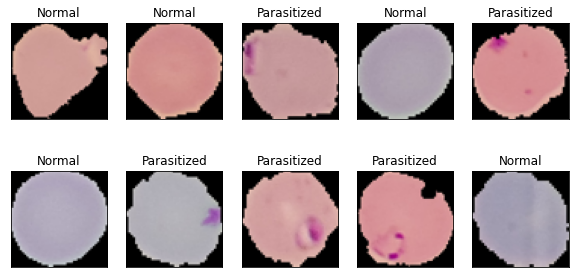

In [12]:
#Vizualization of random images of the training dataset

class_names_list = ['Normal', 'Parasitized']

rows = 2
cols = 5
fig = plt.figure(figsize=(10, 5))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(train_labels))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(train_images[random_index, :])
        ax.set_title(class_names_list[train_labels[random_index]])

plt.show()

* Images are either red or purple in color
* Images are single red blood cell (RBC)
* Normal images RBC have no anomalies
* Parasitized images RBC are mishapen with dark anomalies

In [13]:
# define n X m matrix

def img2np(path, list_of_filename, size = (32, 32)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = IMAGE.load_img(fp, target_size = size, 
                                       color_mode = 'rgb')
        # covert image to a matrix
        img_ts = IMAGE.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
           full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
             # if not assigned yet, assign one
            full_mat = img_ts

    return full_mat


In [14]:
# making n X m matrix for images
normal_images = img2np(f'{train_dir}/uninfected/', normal_imgs)
parasitized_images = img2np(f'{train_dir}/parasitized/', parasitized_imgs)

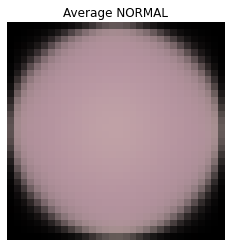

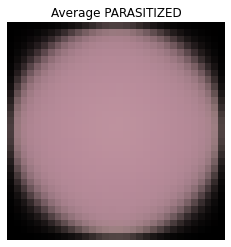

In [15]:
# Average image

def find_mean_img(full_mat, title, size = (32, 32, 3)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    # normalize
    mean_img = mean_img/255
    plt.imshow(mean_img)
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'NORMAL')
parasitized_mean = find_mean_img(parasitized_images, 'PARASITIZED')

# **Build Model 1**

In [16]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [17]:
#Define the function
def cnn_model_1():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", input_shape=(64, 64, 3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(LeakyReLU(0.1))
    model.add(Dense(2, activation='softmax')) 
     
    #declare adam optimizer with learning rate of 0.001 
    adam = optimizers.Adam(learning_rate=0.001)
    
    #compile the model
    model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [18]:
#Build the model
model_1 = cnn_model_1()

In [19]:
#Print the model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1

In [20]:
# Fit the model
history_model_1 = model_1.fit(train_images_normalized, 
                    train_labels_encode,
                    validation_split=0.2, 
                    batch_size=100,
                    epochs=20, 
                    verbose=1)

Epoch 1/20
200/200 [==============================] - 18s 11ms/step - loss: 0.5757 - accuracy: 0.7021 - val_loss: 0.6388 - val_accuracy: 0.6947
Epoch 2/20
200/200 [==============================] - 2s 9ms/step - loss: 0.3010 - accuracy: 0.8794 - val_loss: 0.3382 - val_accuracy: 0.8952
Epoch 3/20
200/200 [==============================] - 2s 9ms/step - loss: 0.2165 - accuracy: 0.9187 - val_loss: 0.3660 - val_accuracy: 0.8758
Epoch 4/20
200/200 [==============================] - 2s 9ms/step - loss: 0.1761 - accuracy: 0.9337 - val_loss: 0.2006 - val_accuracy: 0.9333
Epoch 5/20
200/200 [==============================] - 2s 9ms/step - loss: 0.1632 - accuracy: 0.9403 - val_loss: 0.3897 - val_accuracy: 0.8768
Epoch 6/20
200/200 [==============================] - 2s 9ms/step - loss: 0.1439 - accuracy: 0.9468 - val_loss: 0.2671 - val_accuracy: 0.9165
Epoch 7/20
200/200 [==============================] - 2s 9ms/step - loss: 0.1232 - accuracy: 0.9556 - val_loss: 0.2400 - val_accuracy: 0.9251
Epoc

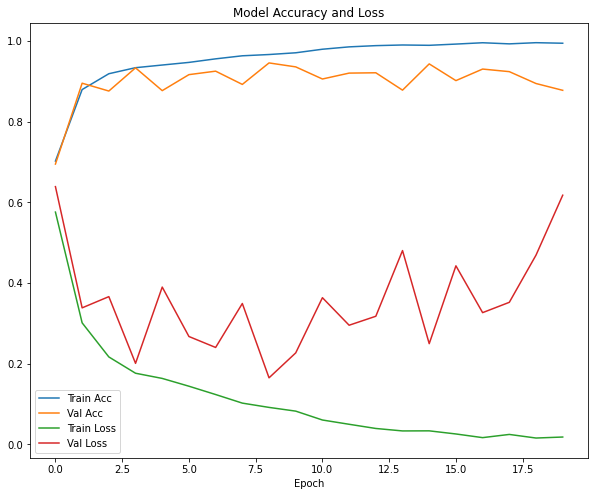

In [21]:
# plotting the accuracy and loss
plt.figure(figsize = (10,8))
plt.plot(history_model_1.history['accuracy'])
plt.plot(history_model_1.history['val_accuracy'])
plt.plot(history_model_1.history['loss'])
plt.plot(history_model_1.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Acc', 'Val Acc','Train Loss', 'Val Loss'], loc='best')
plt.show()

In [22]:
# metrics and confusion matrix

def metrics_score(actual, predicted):
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.0f')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

#Converting each entry to single label from one-hot encoded vector
y_test = np.argmax(test_labels_encode, axis=-1)


              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1300
           1       0.88      0.94      0.91      1300

    accuracy                           0.91      2600
   macro avg       0.91      0.91      0.91      2600
weighted avg       0.91      0.91      0.91      2600



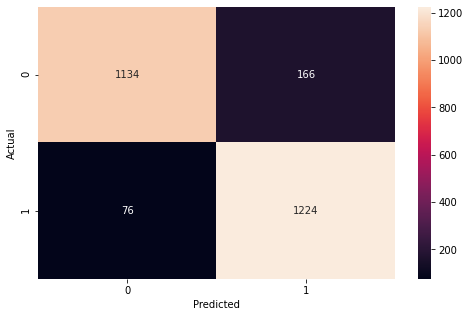

In [23]:
# evaluate the model

test_pred = np.argmax(model_1.predict(test_images_normalized), axis=-1)

metrics_score(y_test, test_pred)

* Model 1 validation accuracy is lower than train accuracy
* Model 1 is overfitting
* Validation loss is high

# **Build Model 2**

In [24]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [25]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [26]:
#Add Dropout layers for overfitting
def cnn_model_2():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", input_shape=(64, 64, 3)))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.2)) #added
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.2)) #added
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(LeakyReLU(0.1))
    model.add(Dense(2, activation='softmax')) 
     
    #declare adam optimizer with learning rate of 0.001 
    adam = optimizers.Adam(learning_rate=0.001)
    
    #compile the model
    model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [27]:
#Build the model
model_2 = cnn_model_2()

In [28]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0

In [29]:
# Fit the model

# smaller batch size
history_model_2 = model_2.fit(train_images_normalized, 
                    train_labels_encode,
                    validation_split=0.2, 
                    batch_size=50,
                    epochs=20, 
                    verbose=1)

Epoch 1/20
400/400 [==============================] - 4s 9ms/step - loss: 0.6218 - accuracy: 0.6871 - val_loss: 0.1668 - val_accuracy: 0.9539
Epoch 2/20
400/400 [==============================] - 3s 7ms/step - loss: 0.3164 - accuracy: 0.8863 - val_loss: 0.1654 - val_accuracy: 0.9549
Epoch 3/20
400/400 [==============================] - 3s 7ms/step - loss: 0.2502 - accuracy: 0.9151 - val_loss: 0.2215 - val_accuracy: 0.9325
Epoch 4/20
400/400 [==============================] - 3s 7ms/step - loss: 0.2222 - accuracy: 0.9232 - val_loss: 0.1393 - val_accuracy: 0.9762
Epoch 5/20
400/400 [==============================] - 3s 7ms/step - loss: 0.1948 - accuracy: 0.9335 - val_loss: 0.2601 - val_accuracy: 0.9435
Epoch 6/20
400/400 [==============================] - 3s 7ms/step - loss: 0.1881 - accuracy: 0.9361 - val_loss: 0.2617 - val_accuracy: 0.9487
Epoch 7/20
400/400 [==============================] - 3s 7ms/step - loss: 0.1630 - accuracy: 0.9433 - val_loss: 0.2064 - val_accuracy: 0.9567
Epoch 

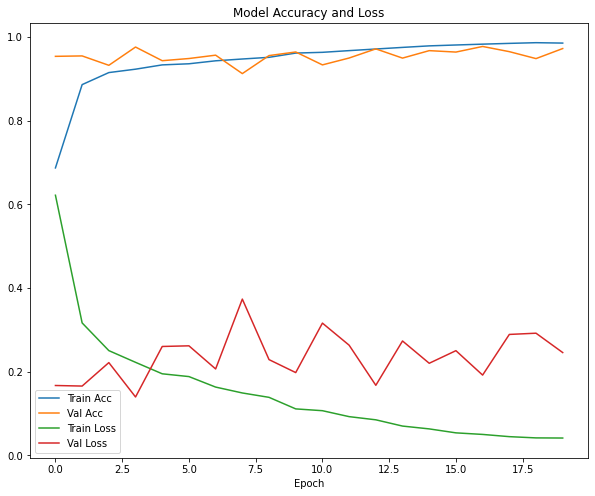

In [30]:
# plotting the accuracy and loss
plt.figure(figsize = (10,8))
plt.plot(history_model_2.history['accuracy'])
plt.plot(history_model_2.history['val_accuracy'])
plt.plot(history_model_2.history['loss'])
plt.plot(history_model_2.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Acc', 'Val Acc','Train Loss', 'Val Loss'], loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1300
           1       0.97      0.90      0.93      1300

    accuracy                           0.93      2600
   macro avg       0.94      0.93      0.93      2600
weighted avg       0.94      0.93      0.93      2600



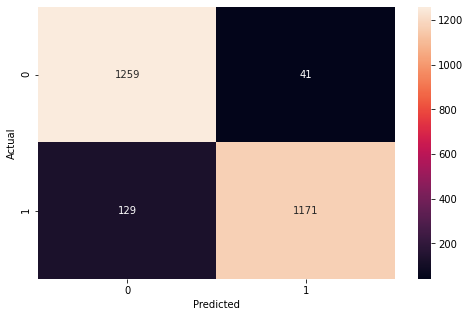

In [31]:
# evaluate the model

test_pred2 = np.argmax(model_2.predict(test_images_normalized), axis=-1)

metrics_score(y_test, test_pred2)

# **Build model 3**

In [32]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [33]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [34]:
#Add convolutional layers
def cnn_model_3():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", input_shape=(64, 64, 3)))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same')) #added
    model.add(LeakyReLU(0.1)) #added
    model.add(Dropout(0.2)) #added
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same')) #added
    model.add(LeakyReLU(0.1)) #addded
    model.add(Dropout(0.2)) #added
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(LeakyReLU(0.1))
    model.add(Dense(2, activation='softmax')) 
     
    #declare adam optimizer with learning rate of 0.001 
    adam = optimizers.Adam(learning_rate=0.001)
    
    #compile the model
    model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [35]:
#Build the model
model_3 = cnn_model_3()

In [36]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1

In [37]:
# Fit the model
history_model_3 = model_3.fit(train_images_normalized, 
                    train_labels_encode,
                    validation_split=0.2, 
                    batch_size=50,
                    epochs=20, 
                    verbose=1)

Epoch 1/20
400/400 [==============================] - 7s 15ms/step - loss: 0.4027 - accuracy: 0.8314 - val_loss: 0.0943 - val_accuracy: 0.9752
Epoch 2/20
400/400 [==============================] - 5s 13ms/step - loss: 0.1601 - accuracy: 0.9456 - val_loss: 0.0607 - val_accuracy: 0.9864
Epoch 3/20
400/400 [==============================] - 5s 13ms/step - loss: 0.1418 - accuracy: 0.9515 - val_loss: 0.0831 - val_accuracy: 0.9798
Epoch 4/20
400/400 [==============================] - 5s 13ms/step - loss: 0.1272 - accuracy: 0.9551 - val_loss: 0.0765 - val_accuracy: 0.9824
Epoch 5/20
400/400 [==============================] - 5s 13ms/step - loss: 0.1163 - accuracy: 0.9578 - val_loss: 0.1199 - val_accuracy: 0.9766
Epoch 6/20
400/400 [==============================] - 5s 13ms/step - loss: 0.1125 - accuracy: 0.9597 - val_loss: 0.0937 - val_accuracy: 0.9800
Epoch 7/20
400/400 [==============================] - 5s 13ms/step - loss: 0.1007 - accuracy: 0.9624 - val_loss: 0.1006 - val_accuracy: 0.9812

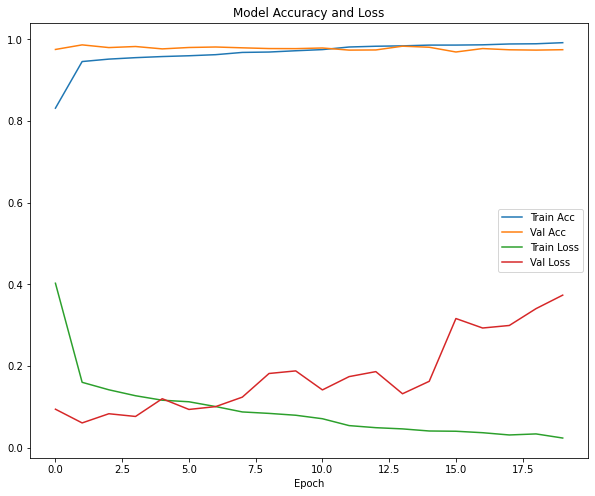

In [38]:
# plotting the accuracy and loss
plt.figure(figsize = (10,8))
plt.plot(history_model_3.history['accuracy'])
plt.plot(history_model_3.history['val_accuracy'])
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Acc', 'Val Acc','Train Loss', 'Val Loss'], loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1300
           1       0.97      0.92      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.95      0.94      0.94      2600
weighted avg       0.95      0.94      0.94      2600



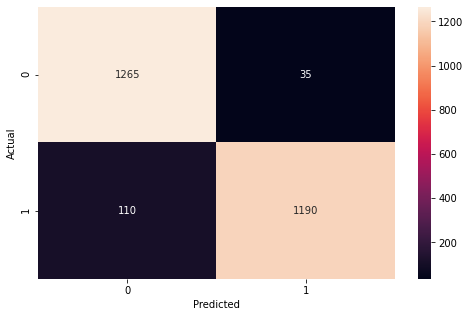

In [39]:
# evaluate the model

test_pred3 = np.argmax(model_3.predict(test_images_normalized), axis=-1)

metrics_score(y_test, test_pred3)

# **Build Model 4**

In [40]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [41]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [42]:
#Add MaxPooling layers
def cnn_model_4():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", input_shape=(64, 64, 3)))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPool2D(pool_size=(2, 2))) #added
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPool2D(pool_size=(2, 2))) #added
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.2))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(LeakyReLU(0.1))
    model.add(Dense(2, activation='softmax')) 
     
    #declare adam optimizer with learning rate of 0.001 
    adam = optimizers.Adam(learning_rate=0.001)
    
    #compile the model
    model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [43]:
#Build the model
model_4 = cnn_model_4()

In [44]:
model_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0

In [45]:
# Fit the model

history_model_4 = model_4.fit(train_images_normalized, 
                    train_labels_encode,
                    validation_split=0.1, #decreased from 0.2 to 0.1
                    batch_size=50,
                    epochs=20, 
                    verbose=1)

Epoch 1/20
450/450 [==============================] - 4s 8ms/step - loss: 0.3304 - accuracy: 0.8468 - val_loss: 0.0759 - val_accuracy: 0.9808
Epoch 2/20
450/450 [==============================] - 3s 7ms/step - loss: 0.1441 - accuracy: 0.9544 - val_loss: 0.0669 - val_accuracy: 0.9780
Epoch 3/20
450/450 [==============================] - 3s 7ms/step - loss: 0.1336 - accuracy: 0.9573 - val_loss: 0.0843 - val_accuracy: 0.9760
Epoch 4/20
450/450 [==============================] - 3s 7ms/step - loss: 0.1269 - accuracy: 0.9591 - val_loss: 0.0963 - val_accuracy: 0.9728
Epoch 5/20
450/450 [==============================] - 3s 7ms/step - loss: 0.1231 - accuracy: 0.9586 - val_loss: 0.0635 - val_accuracy: 0.9808
Epoch 6/20
450/450 [==============================] - 3s 7ms/step - loss: 0.1198 - accuracy: 0.9604 - val_loss: 0.0629 - val_accuracy: 0.9764
Epoch 7/20
450/450 [==============================] - 3s 7ms/step - loss: 0.1154 - accuracy: 0.9606 - val_loss: 0.0533 - val_accuracy: 0.9844
Epoch 

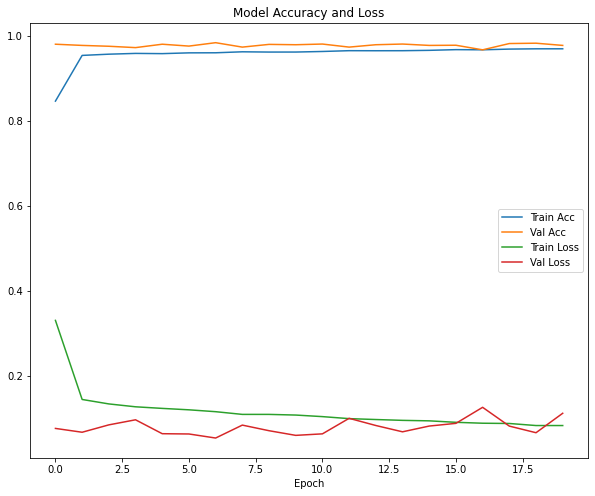

In [46]:
# plotting the accuracy and loss
plt.figure(figsize = (10,8))
plt.plot(history_model_4.history['accuracy'])
plt.plot(history_model_4.history['val_accuracy'])
plt.plot(history_model_4.history['loss'])
plt.plot(history_model_4.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Acc', 'Val Acc','Train Loss', 'Val Loss'], loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1300
           1       0.97      0.94      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.96      0.95      0.95      2600
weighted avg       0.96      0.95      0.95      2600



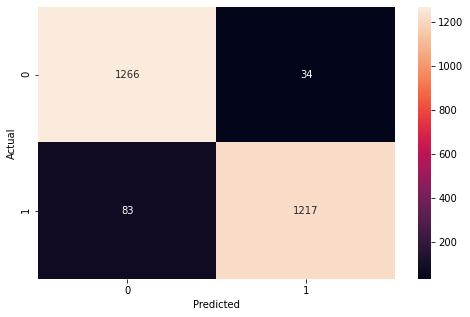

In [47]:
# evaluate the model

test_pred4 = np.argmax(model_4.predict(test_images_normalized), axis=-1)

metrics_score(y_test, test_pred4)

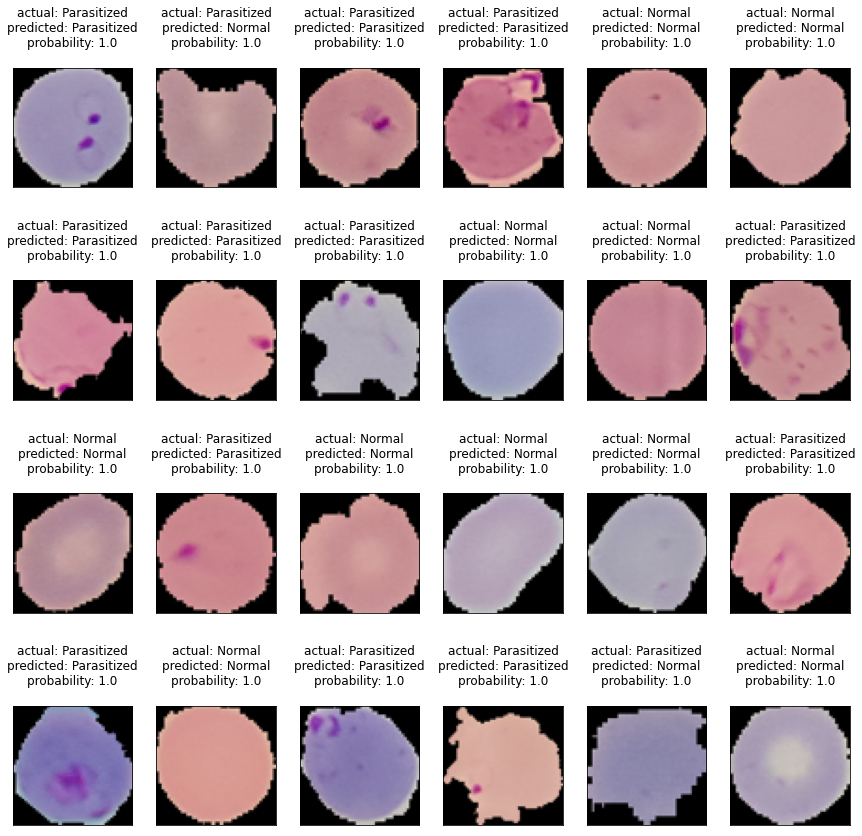

In [48]:
#vizualize images from the test data

rows = 4
cols = 6
fig = plt.figure(figsize=(15, 15))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(test_labels))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(test_images[random_index, :])
        pred_label = class_names_list[test_pred4[random_index]]
        true_label = class_names_list[test_labels[random_index]]
        y_pred_test_max_probas = np.max(model_4.predict(test_images), axis=-1)
        pred_proba = y_pred_test_max_probas[random_index]
        ax.set_title("actual: {}\npredicted: {}\nprobability: {:.3}\n".format(
               true_label, pred_label, pred_proba
        ))
plt.show()

# **Build Model 5**

In [49]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [50]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [51]:
# add convolutional layer and data reshaping layers

from tensorflow.keras.layers import ZeroPadding2D, Cropping2D

def cnn_model_5():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same", input_shape=(64, 64, 3)))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Cropping2D(cropping=((4, 4), (4, 4)))) #added cropping     
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.2))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(ZeroPadding2D(padding=(8, 8))) #added padding     
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same')) #added
    model.add(LeakyReLU(0.1)) #added
    model.add(Dropout(0.2)) #added
    model.add(MaxPool2D(pool_size=(2, 2))) #added    
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(LeakyReLU(0.1))
    model.add(Dense(2, activation='softmax')) 
     
    #declare adam optimizer with learning rate of 0.001 
    adam = optimizers.Adam(learning_rate=0.001)
    
    #compile the model
    model.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [52]:
#Build the model
model_5 = cnn_model_5()

In [53]:
model_5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0

In [54]:
# Fit the model

history_model_5 = model_5.fit(train_images_normalized, 
                    train_labels_encode,
                    validation_split=0.2,
                    batch_size=32,
                    epochs=20, 
                    verbose=1)

Epoch 1/20
624/624 [==============================] - 6s 7ms/step - loss: 0.4817 - accuracy: 0.7540 - val_loss: 0.5584 - val_accuracy: 0.8656
Epoch 2/20
624/624 [==============================] - 4s 7ms/step - loss: 0.3786 - accuracy: 0.8281 - val_loss: 0.5090 - val_accuracy: 0.8934
Epoch 3/20
624/624 [==============================] - 4s 7ms/step - loss: 0.3617 - accuracy: 0.8407 - val_loss: 0.4106 - val_accuracy: 0.8646
Epoch 4/20
624/624 [==============================] - 4s 7ms/step - loss: 0.3560 - accuracy: 0.8427 - val_loss: 0.5001 - val_accuracy: 0.8361
Epoch 5/20
624/624 [==============================] - 4s 7ms/step - loss: 0.3448 - accuracy: 0.8470 - val_loss: 0.4614 - val_accuracy: 0.8411
Epoch 6/20
624/624 [==============================] - 4s 7ms/step - loss: 0.3422 - accuracy: 0.8506 - val_loss: 0.4405 - val_accuracy: 0.9050
Epoch 7/20
624/624 [==============================] - 4s 7ms/step - loss: 0.3414 - accuracy: 0.8472 - val_loss: 0.4151 - val_accuracy: 0.8614
Epoch 

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f26878ac050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


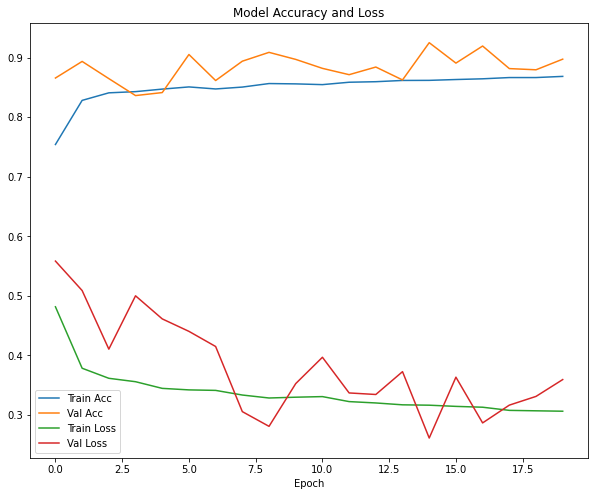

In [55]:
# plotting the accuracy and loss
plt.figure(figsize = (10,8))
plt.plot(history_model_5.history['accuracy'])
plt.plot(history_model_5.history['val_accuracy'])
plt.plot(history_model_5.history['loss'])
plt.plot(history_model_5.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Acc', 'Val Acc','Train Loss', 'Val Loss'], loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1300
           1       0.89      0.85      0.87      1300

    accuracy                           0.88      2600
   macro avg       0.88      0.88      0.88      2600
weighted avg       0.88      0.88      0.88      2600



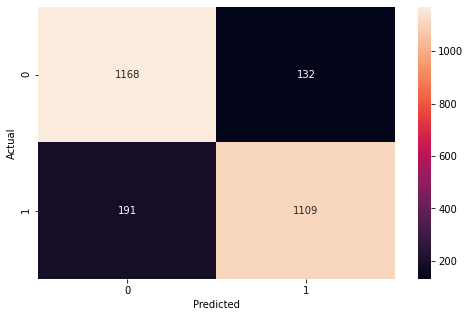

In [56]:
# evaluate the model

test_pred5 = np.argmax(model_5.predict(test_images_normalized), axis=-1)

metrics_score(y_test, test_pred5)

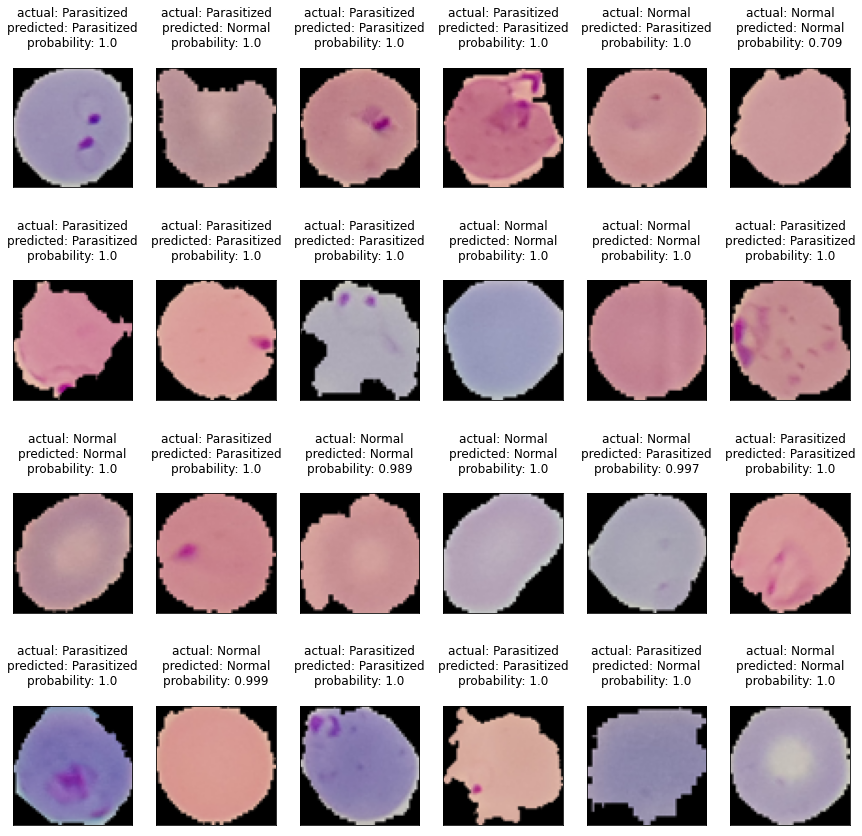

In [57]:
#vizualize images from the test data

rows = 4
cols = 6
fig = plt.figure(figsize=(15, 15))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(test_labels))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(test_images[random_index, :])
        pred_label = class_names_list[test_pred5[random_index]]
        true_label = class_names_list[test_labels[random_index]]
        y_pred_test_max_probas = np.max(model_5.predict(test_images), axis=-1)
        pred_proba = y_pred_test_max_probas[random_index]
        ax.set_title("actual: {}\npredicted: {}\nprobability: {:.3}\n".format(
               true_label, pred_label, pred_proba
        ))
plt.show()

# **Build Model 6 - Hypertuning**

In [66]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [67]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [68]:
#write the tuner function to build the model

def build_model(hp):
    inputs = keras.Input(shape=(64, 64, 3))
    x = inputs
    for i in range(hp.Int("conv_layers", 2, 5, default=3)):
        x = layers.Conv2D(
            filters=hp.Int("conv_filters", 4, 64, step=4, default=8),
            kernel_size=hp.Int("conv_kernel_size", 3, 5),
            activation="relu",
            padding="same",
        )(x)

        x = layers.BatchNormalization()(x)

        if hp.Choice("activation", ["relu", "leaky"]) == "relu":
          x = layers.ReLU()(x)
        else:
          x = layers.LeakyReLU()(x)

        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        
        if hp.Boolean("dropout"):
          x = layers.Dropout(
              rate=hp.Float("drop_rate_1", 0.1, 0.5, step=0.05, default=0.2),
          )(x)
        
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(
        units=hp.Int("dense_units", 8, 64, step=4, default=8),
    )(x)
    x = layers.Dropout(
        rate=hp.Float("drop_rate_2", 0.1, 0.5, step=0.05, default=0.2),
    )(x)
    x = layers.LeakyReLU(0.1)(x)

    # The last layer contains 2 units
    outputs = layers.Dense(2, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    #compile the model
    optimizer = hp.Choice("optimizer", ["adam", "adamax", "sgd"])
    model.compile(
        optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [69]:
# Initialize the `HyperParameters`
hp = kt.HyperParameters()

# Build the model using the `HyperParameters`
hypermodel = build_model(hp)

# model summary
hypermodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 8)         224       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 8)         32        
_________________________________________________________________
re_lu (ReLU)                 (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 8)         32    

In [70]:
#initialize the tuner
tuner_hb = kt.Hyperband(
    build_model,
    seed=42,
    max_epochs=20,
    overwrite=True,
    project_name="hyperband",
    objective="val_accuracy",
)

In [71]:
#start the search
tuner_hb.search(
    train_images_normalized,
    train_labels_encode,
    validation_split=0.2,
    epochs=20,
    shuffle=True,
)

Trial 30 Complete [00h 02m 23s]
val_accuracy: 0.989182710647583

Best val_accuracy So Far: 0.9985977411270142
Total elapsed time: 00h 20m 50s
INFO:tensorflow:Oracle triggered exit


In [72]:
# Show a summary of the search
tuner_hb.results_summary()

Results summary
Results in ./hyperband
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_layers: 4
conv_filters: 8
conv_kernel_size: 4
activation: leaky
dropout: True
dense_units: 28
drop_rate_2: 0.30000000000000004
optimizer: adam
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
drop_rate_1: 0.2
Score: 0.9985977411270142
Trial summary
Hyperparameters:
conv_layers: 4
conv_filters: 44
conv_kernel_size: 5
activation: leaky
dropout: True
dense_units: 24
drop_rate_2: 0.45000000000000007
optimizer: adamax
drop_rate_1: 0.25000000000000006
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 3f4a1cfdef91378ec74287917e0bb867
Score: 0.9983974099159241
Trial summary
Hyperparameters:
conv_layers: 2
conv_filters: 64
conv_kernel_size: 5
activation: relu
dropout: True
dense_units: 40
drop_rate_2: 0.30000000000000004
optimizer: adam
drop_rate_1: 0.20000000000000004
tuner/epochs: 7
tuner/i

In [73]:
# Retrieve the best model
best_model_hb = tuner_hb.get_best_models(num_models=1)[0]

In [74]:
# evaluate the best model
acc_hb = best_model_hb.evaluate(test_images_normalized, test_labels_encode)[1]

82/82 [==============================] - 1s 4ms/step - loss: 0.7207 - accuracy: 0.6292


In [75]:
# Retreive best hyperparameters
best_hp_hb = tuner_hb.get_best_hyperparameters()[0]

In [76]:
# build the model
model_6 = tuner_hb.hypermodel.build(best_hp_hb)

In [77]:
model_6.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 8)         392       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 8)         32        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         1032  

In [78]:
# Fit the model

history_model_6 = model_6.fit(train_images_normalized, 
                    train_labels_encode,
                    validation_split=0.2,
                    batch_size=32,
                    epochs=20,                     
                    verbose=1)

Epoch 1/20
624/624 [==============================] - 5s 6ms/step - loss: 0.6856 - accuracy: 0.6292 - val_loss: 0.6359 - val_accuracy: 0.6508
Epoch 2/20
624/624 [==============================] - 4s 6ms/step - loss: 0.4083 - accuracy: 0.8060 - val_loss: 0.2580 - val_accuracy: 0.9746
Epoch 3/20
624/624 [==============================] - 4s 6ms/step - loss: 0.1943 - accuracy: 0.9338 - val_loss: 0.1057 - val_accuracy: 0.9762
Epoch 4/20
624/624 [==============================] - 4s 6ms/step - loss: 0.1741 - accuracy: 0.9416 - val_loss: 0.0334 - val_accuracy: 0.9908
Epoch 5/20
624/624 [==============================] - 4s 6ms/step - loss: 0.1593 - accuracy: 0.9458 - val_loss: 0.0598 - val_accuracy: 0.9816
Epoch 6/20
624/624 [==============================] - 4s 6ms/step - loss: 0.1587 - accuracy: 0.9479 - val_loss: 0.0519 - val_accuracy: 0.9832
Epoch 7/20
624/624 [==============================] - 4s 6ms/step - loss: 0.1552 - accuracy: 0.9485 - val_loss: 0.1022 - val_accuracy: 0.9690
Epoch 

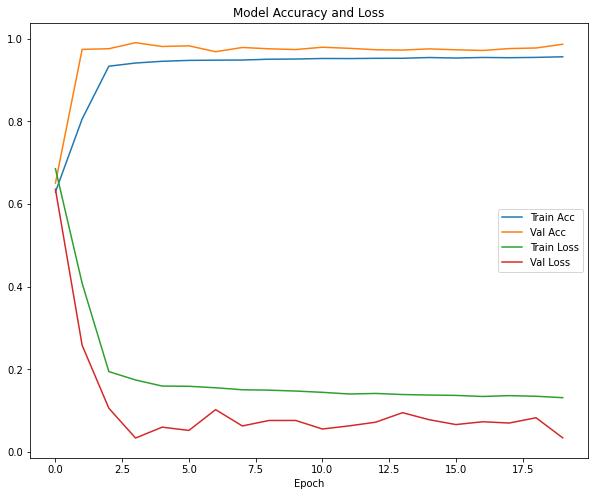

In [79]:
# plotting the accuracy and loss
plt.figure(figsize = (10,8))
plt.plot(history_model_6.history['accuracy'])
plt.plot(history_model_6.history['val_accuracy'])
plt.plot(history_model_6.history['loss'])
plt.plot(history_model_6.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Acc', 'Val Acc','Train Loss', 'Val Loss'], loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1300
           1       0.98      0.90      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.95      0.94      0.94      2600
weighted avg       0.95      0.94      0.94      2600



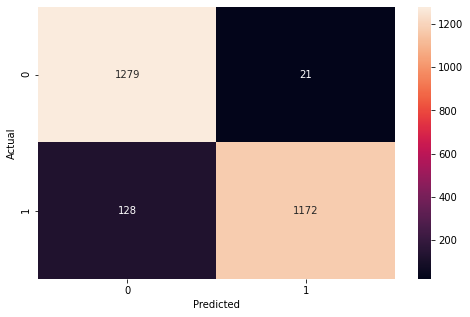

In [80]:
# evaluate the model

test_pred6 = np.argmax(model_6.predict(test_images_normalized), axis=-1)

metrics_score(y_test, test_pred6)

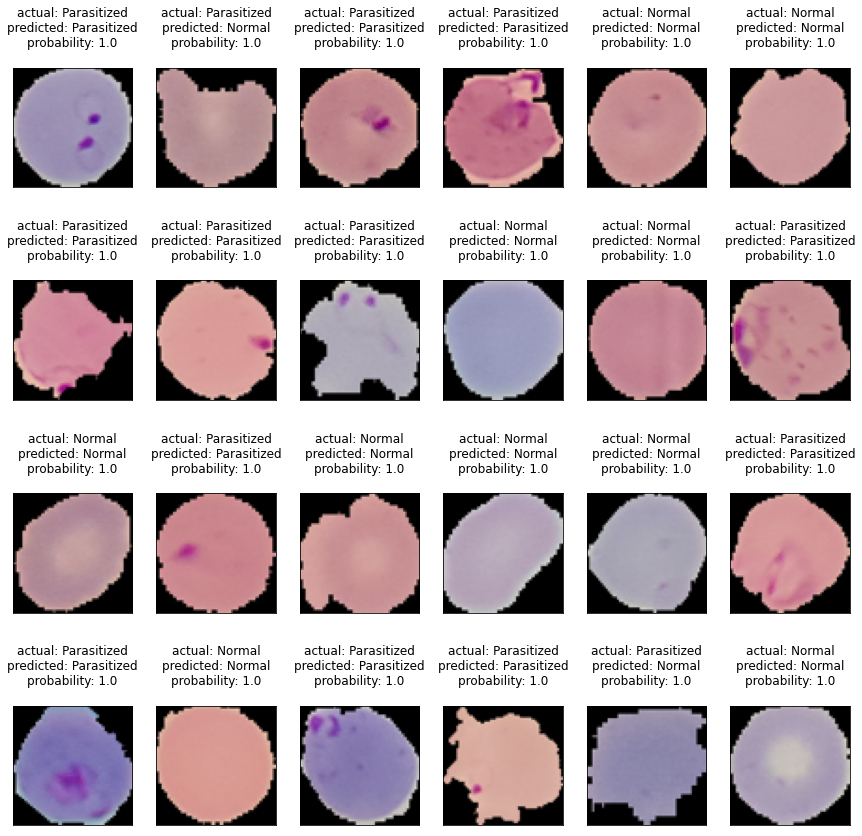

In [81]:
#vizualize images from the test data

rows = 4
cols = 6
fig = plt.figure(figsize=(15, 15))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(test_labels))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(test_images[random_index, :])
        pred_label = class_names_list[test_pred6[random_index]]
        true_label = class_names_list[test_labels[random_index]]
        y_pred_test_max_probas = np.max(model_6.predict(test_images), axis=-1)
        pred_proba = y_pred_test_max_probas[random_index]
        ax.set_title("actual: {}\npredicted: {}\nprobability: {:.3}\n".format(
               true_label, pred_label, pred_proba
        ))
plt.show()

# **Build Model 7 - Transfer Learning**

In [82]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [83]:
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [84]:
#Importing necessary libraries
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16

In [85]:
#build the model
vgg_model = VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(64, 64, 3), pooling='max')

In [86]:
# model summary
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [87]:
# output of fourth block from the VGG16 model
transfer_layer = vgg_model.get_layer('block4_pool')

In [88]:
# do not train layers of the VGG16 model
vgg_model.trainable=False

In [89]:
# add classification layers
 
x = Flatten()(transfer_layer.output) #Flatten the output from the 3rd block of the VGG16 model
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
pred = Dense(2, activation='softmax')(x)

# initialize the model
model_7 = Model(vgg_model.input, pred) 

In [90]:
# compile the model
model_7.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

In [91]:
# Fit the model

history_model_7 = model_7.fit(train_images_normalized, 
                    train_labels_encode,
                    validation_split=0.2,
                    batch_size=64,
                    epochs=20, 
                    verbose=1)

Epoch 1/20
312/312 [==============================] - 6s 15ms/step - loss: 0.2747 - accuracy: 0.8863 - val_loss: 0.1214 - val_accuracy: 0.9553
Epoch 2/20
312/312 [==============================] - 4s 13ms/step - loss: 0.1747 - accuracy: 0.9338 - val_loss: 0.4241 - val_accuracy: 0.8241
Epoch 3/20
312/312 [==============================] - 4s 13ms/step - loss: 0.1483 - accuracy: 0.9446 - val_loss: 0.1346 - val_accuracy: 0.9507
Epoch 4/20
312/312 [==============================] - 4s 12ms/step - loss: 0.1396 - accuracy: 0.9474 - val_loss: 0.0946 - val_accuracy: 0.9643
Epoch 5/20
312/312 [==============================] - 4s 12ms/step - loss: 0.1217 - accuracy: 0.9549 - val_loss: 0.7117 - val_accuracy: 0.6801
Epoch 6/20
312/312 [==============================] - 4s 12ms/step - loss: 0.1137 - accuracy: 0.9587 - val_loss: 0.1564 - val_accuracy: 0.9373
Epoch 7/20
312/312 [==============================] - 4s 12ms/step - loss: 0.1088 - accuracy: 0.9596 - val_loss: 0.1452 - val_accuracy: 0.9451

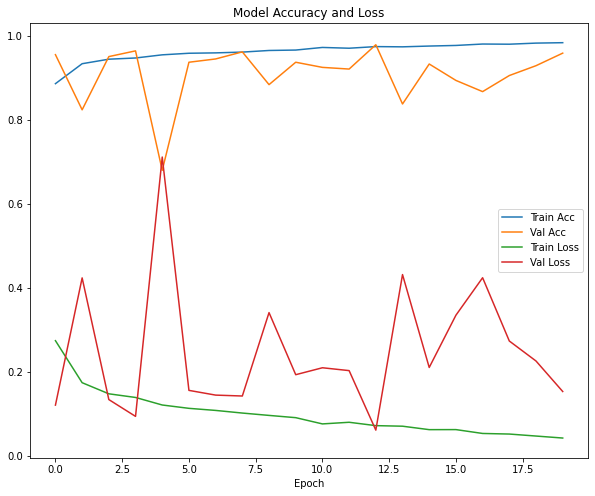

In [92]:
# plotting the accuracy and loss
plt.figure(figsize = (10,8))
plt.plot(history_model_7.history['accuracy'])
plt.plot(history_model_7.history['val_accuracy'])
plt.plot(history_model_7.history['loss'])
plt.plot(history_model_7.history['val_loss'])
plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(['Train Acc', 'Val Acc','Train Loss', 'Val Loss'], loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1300
           1       0.96      0.93      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



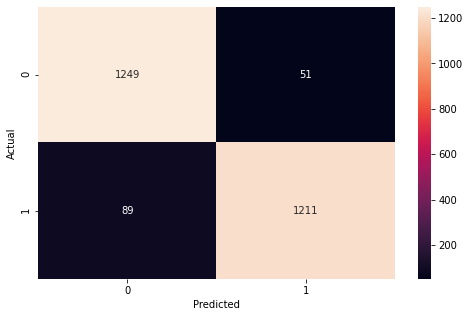

In [93]:
# evaluate the model

test_pred7 = np.argmax(model_7.predict(test_images_normalized), axis=-1)

metrics_score(y_test, test_pred7)

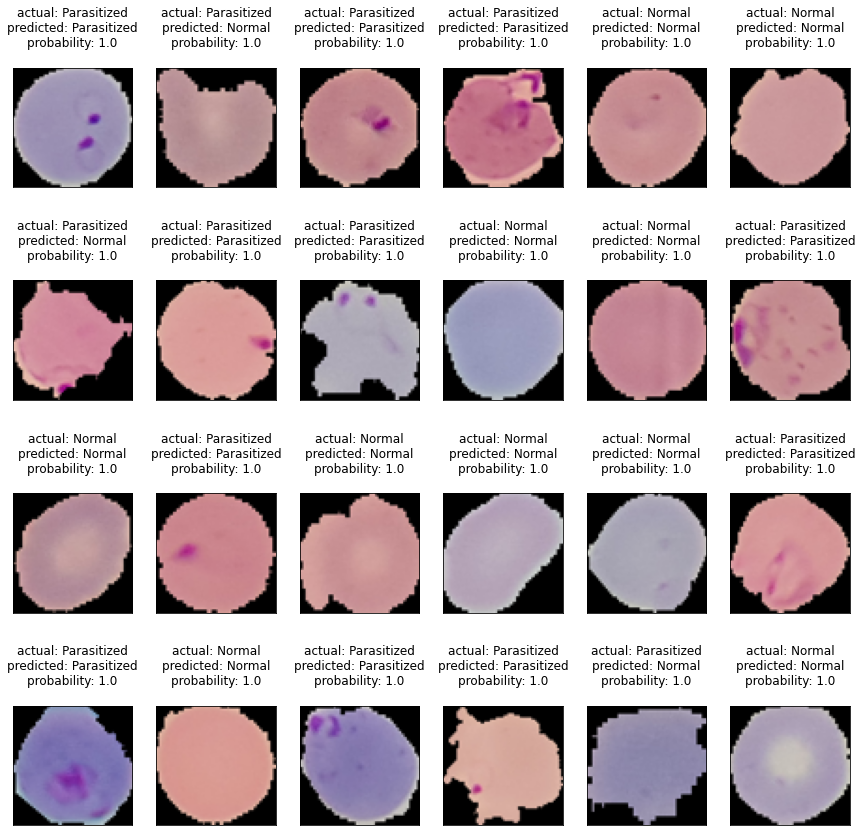

In [94]:
#vizualize images from the test data

rows = 4
cols = 6
fig = plt.figure(figsize=(15, 15))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(test_labels))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(test_images[random_index, :])
        pred_label = class_names_list[test_pred7[random_index]]
        true_label = class_names_list[test_labels[random_index]]
        y_pred_test_max_probas = np.max(model_7.predict(test_images), axis=-1)
        pred_proba = y_pred_test_max_probas[random_index]
        ax.set_title("actual: {}\npredicted: {}\nprobability: {:.3}\n".format(
               true_label, pred_label, pred_proba
        ))
plt.show()

# **Model Comparison**

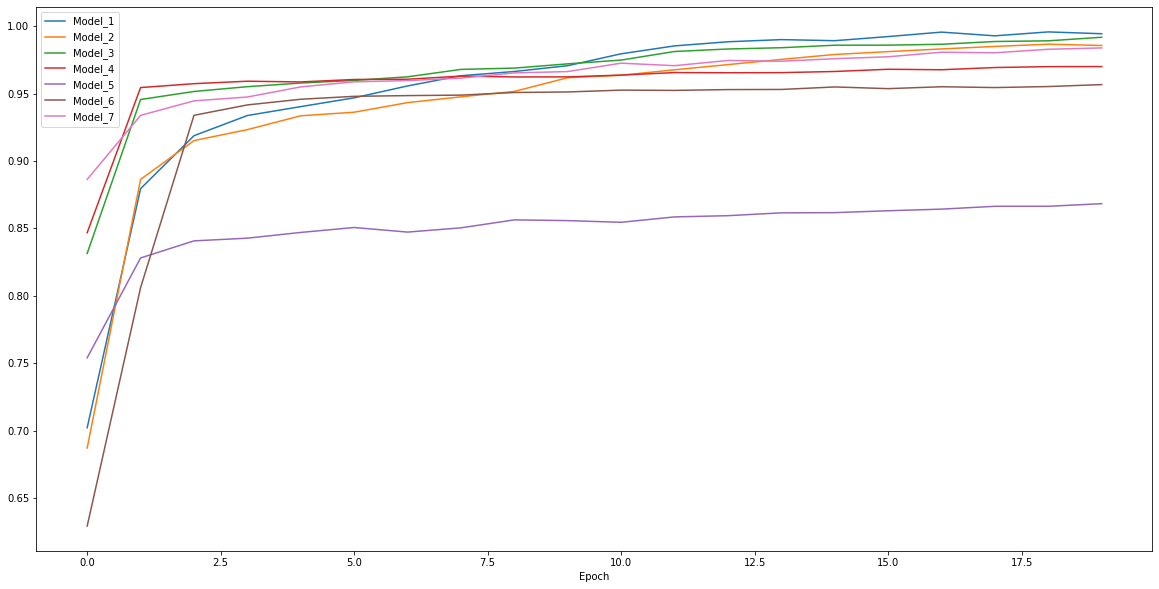

In [96]:
# plotting the train accuracy
plt.figure(figsize = (20,10))
plt.plot(history_model_1.history['accuracy'])
plt.plot(history_model_2.history['accuracy'])
plt.plot(history_model_3.history['accuracy'])
plt.plot(history_model_4.history['accuracy'])
plt.plot(history_model_5.history['accuracy'])
plt.plot(history_model_6.history['accuracy'])
plt.plot(history_model_7.history['accuracy'])
plt.xlabel('Epoch')
plt.legend(['Model_1','Model_2','Model_3','Model_4','Model_5','Model_6','Model_7'], loc='best')
plt.show()

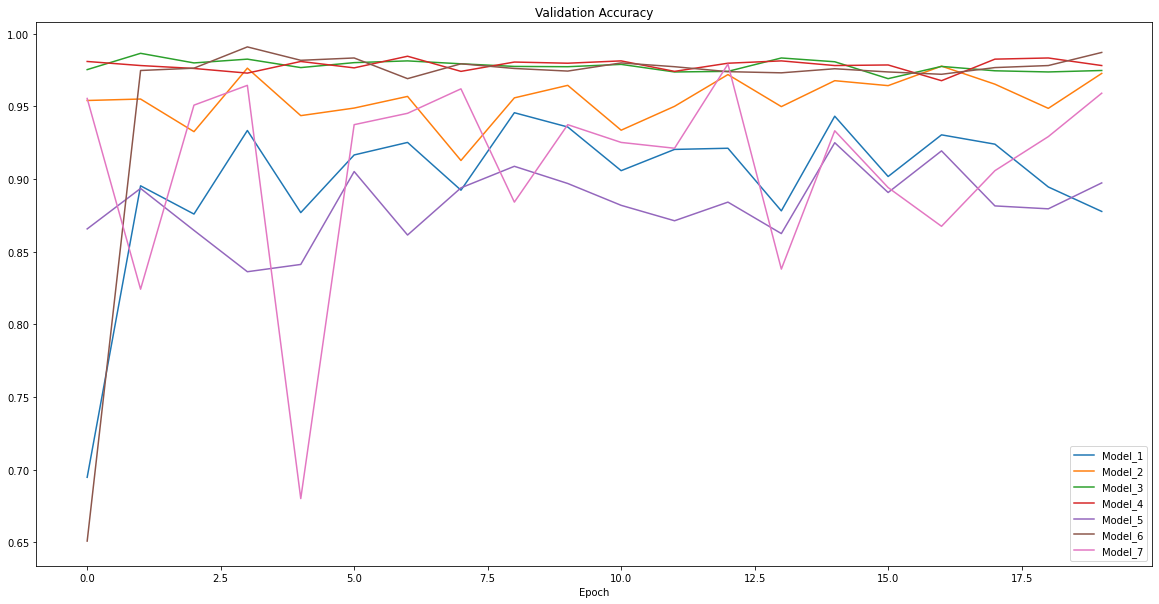

In [97]:
# plotting the validation accuracy
plt.figure(figsize = (20,10))
plt.plot(history_model_1.history['val_accuracy'])
plt.plot(history_model_2.history['val_accuracy'])
plt.plot(history_model_3.history['val_accuracy'])
plt.plot(history_model_4.history['val_accuracy'])
plt.plot(history_model_5.history['val_accuracy'])
plt.plot(history_model_6.history['val_accuracy'])
plt.plot(history_model_7.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['Model_1','Model_2','Model_3','Model_4','Model_5','Model_6','Model_7'], loc='best')
plt.show()

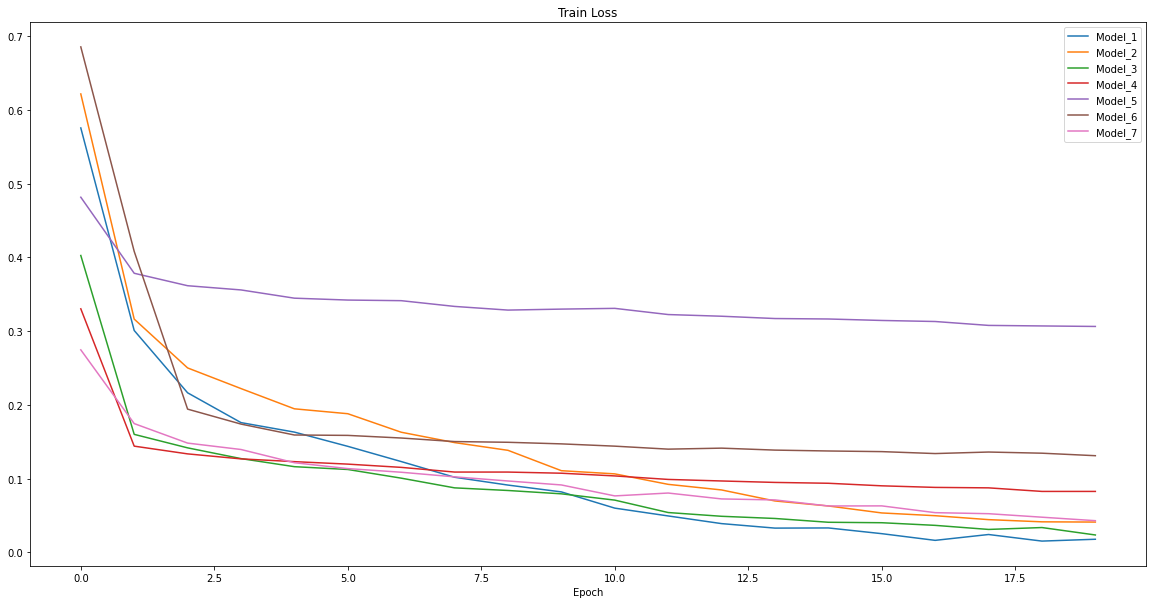

In [98]:
# plotting the train loss
plt.figure(figsize = (20,10))
plt.plot(history_model_1.history['loss'])
plt.plot(history_model_2.history['loss'])
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_4.history['loss'])
plt.plot(history_model_5.history['loss'])
plt.plot(history_model_6.history['loss'])
plt.plot(history_model_7.history['loss'])
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.legend(['Model_1','Model_2','Model_3','Model_4','Model_5','Model_6','Model_7'], loc='best')
plt.show()

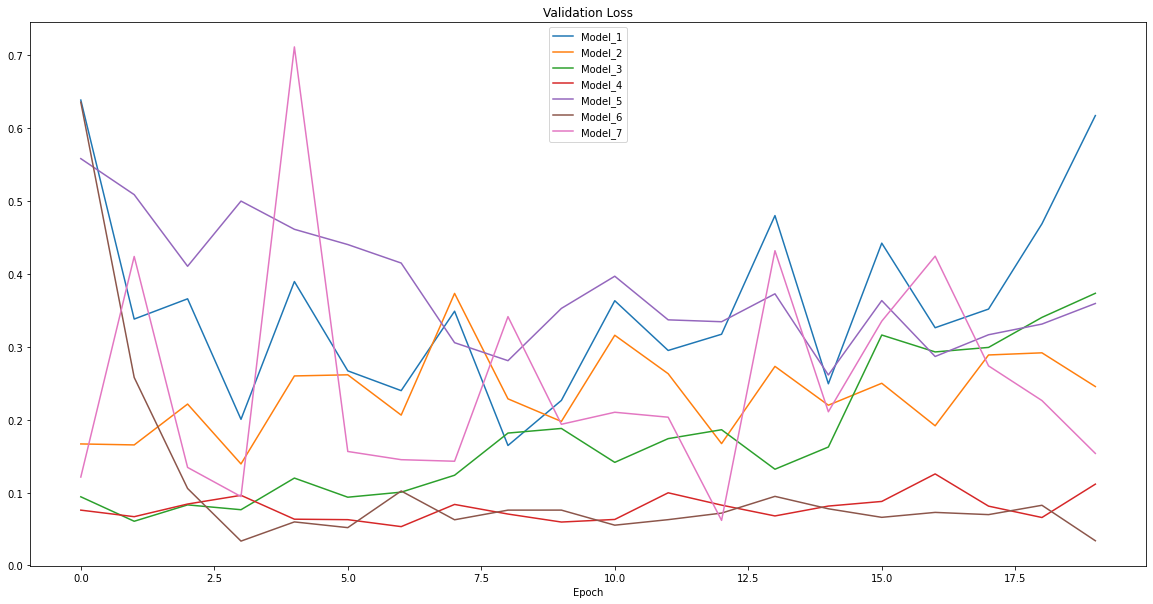

In [99]:
# plotting the validation loss
plt.figure(figsize = (20,10))
plt.plot(history_model_1.history['val_loss'])
plt.plot(history_model_2.history['val_loss'])
plt.plot(history_model_3.history['val_loss'])
plt.plot(history_model_4.history['val_loss'])
plt.plot(history_model_5.history['val_loss'])
plt.plot(history_model_6.history['val_loss'])
plt.plot(history_model_7.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['Model_1','Model_2','Model_3','Model_4','Model_5','Model_6','Model_7'], loc='best')
plt.show()